# Review DPS outputs
Make a mosaic of DPS outputs.

1. make a list of the DPS output paths with build_tindex.master.py
2. Identify duplicate tiles
3. Identify matching tiles; merge tindex.master with the original index tile file
4. make mosaicjson
5. View DPS results

In [1]:
import geopandas
import pandas as pd
import os
import json
import collections
import numpy as np
import sys
import s3fs
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')

import ExtractUtils
!pip install pystac
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
import maplib_folium
def local_to_s3(url, user = 'nathanmthomas', type='public'):
    ''' A Function to convert local paths to s3 urls'''
    if type is 'public':
        replacement_str = f's3://maap-ops-workspace/shared/{user}'
    else:
        replacement_str = f's3://maap-ops-workspace/{user}'
    return url.replace(f'/projects/my-{type}-bucket', replacement_str)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Choose a DPS data type; get its tile index master file
Get a filename of the master list DPS output tiles returned with _build_tindex_master.py

In [2]:
DPS_DATA_TYPE = 'ATL08_filt' #\"Topo\" \"Landsat\" \"ATL08\" \"ATL08_filt\" \"AGB\"
DPS_DATA_USER = 'nathanmthomas' #'nathanmthomas' 'lduncanson'
TEST_HLS = False
DPS = True
OUT_MASTER_CSV_JSON_DIR = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists'

if DPS_DATA_TYPE == 'HLS':
    if TEST_HLS:
        # Run tests on set of NORWAY + AK + MISC or any other tiles of interest in DPS_mscomp nb
        # misc tests 
        #NAME_HLS_TEST = 'test_mc0_3yrs'
        #NAME_HLS_TEST = 'test_single_years'
        #NAME_HLS_TEST = '03'
        #DAY_START_TEST = 24

        # better tests
        #NAME_HLS_TEST = 'test_mc10_3yrs'
        #DAY_START_TEST = 23
        NAME_HLS_TEST = '03' #'test_mc40_3yrs'
        DAY_START_TEST = 24

        ENDSTR = '.tif'
        if DPS:
            OUT_MASTER_CSV_JSON_DIR = f's3://maap-ops-workspace/{DPS_DATA_USER}/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/{NAME_HLS_TEST}'  #LOCAL_WRITE_DIR = f'/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/{NAME_HLS_TEST}'
            !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m $NAME_HLS_TEST -d_min $DAY_START_TEST -o $OUT_MASTER_CSV_JSON_DIR --ends_with_str $ENDSTR,
        else:
            LOCAL_DIR_PART = f'shared/nathanmthomas/test_hls/{NAME_HLS_TEST}',
            OUT_MASTER_CSV_JSON_DIR = f'/projects/my-public-bucket/test_hls/{NAME_HLS_TEST}',
            !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS --LOCAL_TEST -local_dir $LOCAL_DIR_PART -o $OUT_MASTER_CSV_JSON_DIR --ends_with_str $ENDSTR,
    else:
        NAME_HLS = '03 04' #'test_mc40_3yrs'
        DAY_START = 24
        #NAME_HLS = '04' #'test_mc40_3yrs'
        #DAY_START = 5
        #OUT_MASTER_CSV_JSON_DIR = f'/projects/shared-buckets/{DPS_DATA_USER}/DPS_tile_lists'
        
        !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m_list $NAME_HLS #-d_min $DAY_START

tindex_master_fn        = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.csv')
tile_matches_geojson_fn = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master.json')
out_mosaic_json_fn      = os.path.join(OUT_MASTER_CSV_JSON_DIR, f'{DPS_DATA_TYPE}_tindex_master_mosaic.json')

#tindex_master_fn = '/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/run_LC_height_thresholds/ATL08_filt_tindex_master.csv'

#Get other tile index master files
ATL08_filt_sample_tindex_master_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_sample_tindex_master.csv'
#ATL08_filt_tindex_master_fn       = '/projects/test_dps/ATL08_filt_tindex_master.csv'#'s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_tindex_master.csv'
ATL08_filt_tindex_master_fn        = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv'
#ATL08_filt_tindex_master_fn        = 's3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/master/2022/03/ATL08_filt_tindex_master.csv'
Topo_tindex_master_fn              = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv'

Topo_tindex_master                 =  pd.read_csv(Topo_tindex_master_fn)
ATL08_filt_tindex_master           =  pd.read_csv(ATL08_filt_tindex_master_fn)
ATL08_filt_sample_tindex_master    =  pd.read_csv(ATL08_filt_sample_tindex_master_fn)


In [3]:
UPDATE_TINDEX = False

if not os.path.isfile(tindex_master_fn):
     UPDATE_TINDEX = True
else:
    print('Using existing tindex')
    print(tindex_master_fn)

    
if UPDATE_TINDEX:
    print(f"Building master tile index for: {DPS_DATA_TYPE}")
    dps_month = 'run_LC_height_thresholds'
    d_min = 1
    #os.system(f"python /projects/icesat2_boreal/lib/build_tindex_master.py --type {DPS_DATA_TYPE} -m {dps_month} -d_min {d_min}")
    #!python /projects/icesat2_boreal/lib/build_tindex_master_v2.py --type $DPS_DATA_TYPE -m $dps_month -d_min $d_min


Building master tile index for: ATL08_filt


### Get the tiles needed for the data of interest

In [4]:
# Build up a dataframe from the list of dps output files
tindex_master = pd.read_csv(tindex_master_fn)

if DPS_DATA_TYPE == 'Landsat' or DPS_DATA_TYPE == 'HLS' or DPS_DATA_TYPE == 'Topo':
    DPS_DATA_USER = 'nathanmthomas'
    
tindex_master['s3'] = [local_to_s3(local_path, user=DPS_DATA_USER, type = 'private') for local_path in tindex_master['local_path']]
print(f"# of expected {DPS_DATA_TYPE} tiles:\t\t\t\t\t\t{len(tindex_master)}")

# Wherever there is a 90k Topo tile, there should be data...
# Get all covar tiles that should account for the set of output we want
topo_tindex_master  = pd.read_csv(Topo_tindex_master_fn)
print(f"# of expected covar (from Topo) tiles:\t\t\t\t\t{len(topo_tindex_master.tile_num )}")

# Get all boreal tiles
boreal_tile_index_path = '/projects/my-public-bucket/boreal_tiles_v003.gpkg' 
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)
#boreal_tile_index.astype({'layer':'int'})
#boreal_tile_index.rename(columns={"layer":"tile_num"}, inplace=True)
boreal_tile_index["tile_num"] = boreal_tile_index["tile_num"].astype(int)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.
# For some reason, doing this causes 'MosaicJSON.from_features()' to fail...(below)
if True:
    # Remove bad tiles
    boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]
    
    
select_needs = [3360,2994,3190,2840,3012,3014,3017,2932,1261,1263,1264,988,978,794, 380,378,411,821,861,
                812,765,764,1308,1302,1469,1406,2495,2883,2965,3321,3509,3510,3327,3335,2976,2906,2907,2894,2814,4253,4293,4403,4440,4408,4372,4477,3986]
tile_matches_select_needs = boreal_tile_index.merge(ATL08_filt_tindex_master[ATL08_filt_tindex_master['tile_num'].isin(select_needs)], how='right', on='tile_num')
print(f"# of {DPS_DATA_TYPE} tiles needed (compared with {os.path.basename(ATL08_filt_tindex_master_fn)}):\t{len(tile_matches_select_needs)}")

print(f"# of total tiles supposedly needed (from {os.path.basename(boreal_tile_index_path)}):\t{len(boreal_tile_index)}")

if len(tile_matches_select_needs)<100:
    print([t for t in tile_matches_select_needs.tile_num])


# of expected ATL08_filt tiles:						4581
# of expected covar (from Topo) tiles:					5220
# of ATL08_filt tiles needed (compared with ATL08_filt_tindex_master.csv):	47
# of total tiles supposedly needed (from boreal_tiles_v003.gpkg):	5331
[4253, 2894, 3012, 3360, 1264, 3190, 4403, 4477, 4372, 4293, 988, 4408, 3321, 3986, 1263, 380, 378, 411, 3327, 812, 978, 3509, 764, 794, 2932, 2907, 4440, 765, 861, 3335, 1469, 3014, 1261, 1308, 2840, 2495, 1406, 1302, 3017, 2906, 2883, 2994, 2965, 3510, 2814, 2976, 821]


### Identify duplicate tiles

In [5]:
duplicate_tiles = [item for item, count in collections.Counter(tindex_master["tile_num"]).items() if count > 1]
print(duplicate_tiles)

[]


### Identify completed, missing, failed, & duplicate tiles

Tile status report for ATL08_filt from s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv:
	# tiles matched:		4581
	# tiles missing:		0
	# tiles duplicated: 		0
Missing tiles:	[]
Bad tiles:	[3540, 3634, 3728, 3823, 3916, 4004]


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


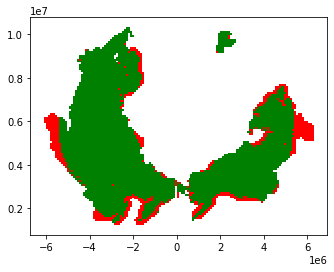

In [6]:
print(f"Tile status report for {DPS_DATA_TYPE} from {tindex_master_fn}:")
# For the tindex_master, convert it into vector tiles that show the tiles we have
# Select the rows we have results for
tile_index_matches = boreal_tile_index.merge(tindex_master[~tindex_master['tile_num'].isin(bad_tiles)][['tile_num','s3_path','local_path']], how='right', on='tile_num')
#tile_matches_atl08_filt_samples = boreal_tile_index.merge(ATL08_filt_sample_tindex_master[~ATL08_filt_sample_tindex_master['tile_num'].isin(bad_tiles)], how='right', on='tile_num')
print(f'\t# tiles matched:\t\t{len(tile_index_matches)}')

# Use the Topo tiles (COVAR set) to get the diff of what tiles we have and what we want
# MISSING TILES = DIFF(tiles_we_want, tiles_we_have)
#tile_nums_missing = np.setdiff1d(tiles_covars, tile_index_matches.tile_num)
tile_nums_missing_list = list(set(topo_tindex_master.tile_num) - set(tile_index_matches.tile_num))
tile_nums_missing_list = list(set(tile_index_matches.tile_num) - set(topo_tindex_master.tile_num))
# The ATL08 tiles we have may not exactly match the set of COVAR tiles we have
# Use the set of ATL08 tiles we have, crossed with the tiles we're missing (based on COVAR set), to get tiles we're missing that we should definitely proces (b/c we have both COVAR and ATL08 tiles for them)
#tile_index_missing = boreal_tile_index.merge(boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_nums_missing_list)], how='right', on='tile_num')
#tile_index_missing = boreal_tile_index.merge(tindex_master[tindex_master['tile_num'].isin(tile_nums_missing_list)], how='inner', on='tile_num')
tile_index_missing = boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_nums_missing_list)]

print(f'\t# tiles missing:\t\t{len(tile_index_missing)}')
if len(tile_index_missing) > 0:
    tile_index_missing.to_file(f'/projects/my-public-bucket/DPS_tile_lists/Need_{DPS_DATA_TYPE}_tindex_master.gpkg', driver='GPKG')
    #print(tile_index_missing.head())

# Meh, this doesnt give us fails
#tile_matches_failed = boreal_tile_index.merge(Topo_tindex_master[Topo_tindex_master['tile_num'].isin(tile_nums_missing)], how='right', on='tile_num')
#print(f'Missing b/c failed: \t{len(tile_matches_failed)}')

# Duplicates are also removed in build_tindex_master
tile_matches_duplicates = boreal_tile_index.merge(topo_tindex_master.tile_num[topo_tindex_master.tile_num.isin(duplicate_tiles)], how='right', on='tile_num')
print(f'\t# tiles duplicated: \t\t{len(tile_matches_duplicates)}')

# Drop duplicates
tile_index_matches = tile_index_matches.drop_duplicates(subset=['tile_num'], keep='last')
print(f"Missing tiles:\t{tile_nums_missing_list}")
print(f"Bad tiles:\t{bad_tiles}")

ax = boreal_tile_index.plot(color='red')
ax = tile_index_matches.plot(color='green', ax=ax)
tile_index_missing.plot(column='tile_group', ax=ax)


                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              98
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            358
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for ATL08_filt from s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv:
	# of boreal tiles in boreal v003:			5337
	# of boreal tiles in water:				0
	# of boreal tiles used study (from Topo coverage):	5337
	# of boreal tiles with ATL08_filt:				4581
	# of boreal tiles still needing ATL08_filt from all:	756


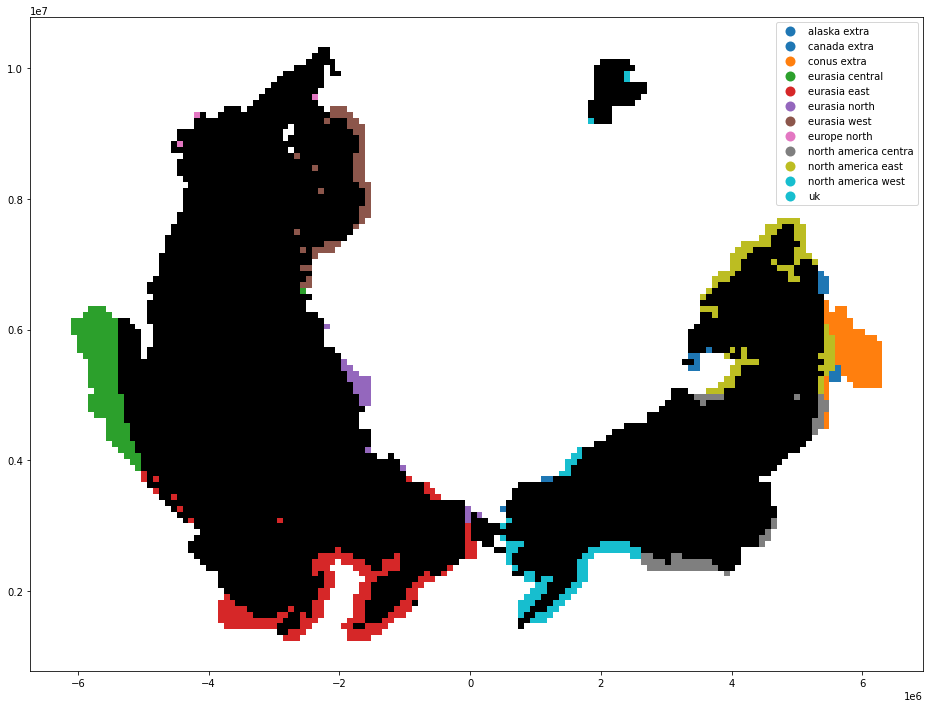

In [7]:
TILE_ATL08_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'ATL08_filt', \
                                                tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv',\
                                                boreal_tile_index_path = '/projects/my-public-bucket/boreal_tiles_v003.gpkg')

In [8]:
if 's3_path' in tile_index_matches.columns:
    tile_index_matches['s3'] = tile_index_matches['s3_path']
    
tile_index_matches = tile_index_matches[tile_index_matches['s3'].notna()]
tile_index_matches.head()

,tile_num,tile_version,tile_group,map_version,geometry,s3_path,local_path,s3
0,4253,version 1,eurasia east,None,"POLYGON ((-1161478.000 2223304.000, -1071478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_til...,s3://maap-ops-workspace/lduncanson/dps_output/...
1,3896,version 1,eurasia east,None,"POLYGON ((-1881478.000 2673304.000, -1791478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_til...,s3://maap-ops-workspace/lduncanson/dps_output/...
2,3411,version 1,eurasia east,None,"POLYGON ((-3501478.000 3123304.000, -3411478.0...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_til...,s3://maap-ops-workspace/lduncanson/dps_output/...
3,2273,version 1,north america west,None,"POLYGON ((2258522.000 4383304.000, 2348522.000...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_til...,s3://maap-ops-workspace/lduncanson/dps_output/...
4,2530,version 1,north america centra,None,"POLYGON ((3878522.000 4113304.000, 3968522.000...",s3://maap-ops-workspace/lduncanson/dps_output/...,/projects/my-private-bucket/dps_output/run_til...,s3://maap-ops-workspace/lduncanson/dps_output/...


## Build a MosaicJSON

##### Build tile geojsons needed for mosaic jsons

In [9]:
tile_matches_geojson_string = tile_index_matches.to_crs("EPSG:4326").to_json()
tile_matches_geojson = json.loads(tile_matches_geojson_string)
#Write copy to disk for debug
#tile_matches_geojson_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master.json' 
tile_index_matches.to_file(tile_matches_geojson_fn, driver='GeoJSON')

if len(tile_index_missing) > 0:
    tile_index_missing_geojson_string = tile_index_missing.to_crs("EPSG:4326").to_json()
    tile_index_missing_geojson = json.loads(tile_index_missing_geojson_string)

from typing import Dict
from cogeo_mosaic.mosaic import MosaicJSON
from cogeo_mosaic.backends import MosaicBackend

def get_accessor(feature: Dict):
    """Return specific feature identifier."""
    return feature["properties"]["s3"]

#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/{DPS_DATA_USER}/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 
#out_mosaic_json_fn = f's3://maap-ops-workspace/shared/alexdevseed/DPS_tile_lists/{DPS_DATA_TYPE}_tindex_master_mosaic.json' 

print(f"Building {out_mosaic_json_fn}")
mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

with MosaicBackend(out_mosaic_json_fn, mosaic_def=mosaicdata) as mosaic:
    mosaic.write(overwrite=True)

Building s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master_mosaic.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


## View the Results with Folium

In [10]:
from folium import Map, TileLayer, GeoJson, LayerControl, Icon, Marker, features, Figure, CircleMarker
from folium import plugins

# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

import branca.colormap as cm
import matplotlib.cm
pal_height_cmap = cm.LinearColormap(colors = ['black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850'], vmin=0, vmax=10)
pal_height_cmap.caption = 'Vegetation height from  ATL08 @ 30 m (h_can; rh98)'
#pal_height_cmap

dem_tiles_index_path = '/projects/shared-buckets/nathanmthomas/dem30m_tiles.geojson'
dem_tiles_index = geopandas.read_file(dem_tiles_index_path)
dem_tiles_index['tile_num'] = dem_tiles_index.index
dem_tiles_index.to_file('/projects/my-public-bucket/dem30m_tiles_v2.geojson', driver='GeoJSON')

bandnames = ['Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCB', 'TCG', 'TCW', 'ValidMask', 'Xgeo', 'Ygeo', 'JulianDate', 'yearDate']


In [11]:
CHECK_TILES = [1043, 34675, 34674, 34676, 35126, 35125, 35352, 1216, 3193, 3286, 3380, 3938]
CHECK_TILES = ATL08_filt_tindex_master.tile_num.to_list()
CHECK_TILES = [600, 601, 604, 643, 642, 728, 774, 775, 820, 821, 867, 868, 869, 1080, 917, 918]
REDO_TILES = [636, 637, 68, 681, 27641, 27642, 27643, 27912, 27913, 28181, 25736, 26288, 26289, 26563, 26835, 26016, 26017, \
              range(26292,26294+1), 26568, 25180, 24899, 24336, 24337, 24617, 24055, 22937, range(23217, 23219+1), 23499, 24059, 24339, 24340, 24620, 24621, 24063 ]
REDO_TILES = [
                1043, 1044, \
                34675, 34674, 34676, 35126, 35125, 35352, 1216,
                3193, 3286, 3380, 3938, 3949
             ]
REDO_TILES = [887,888,940, 941, 992, 993,1050, 1214,1215, 1216, 35352] + list(range(34674,34676+1))+ list(range(982,986+1))+ list(range(1041,1044+1))+ list(range(789,791+1))+ list(range(835,836+1))+ list(range(1613,1615+1))+ list(range(1557,1558+1))+\
                list(range(3004,3005+1)) +[2819] + list(range(3089,3097+1)) + list(range(3181,3186+1)) +[3367,3373, 3274, 3279, 3280, 3379, 3380, 3568, 3569, 3662]+list(range(3285,3288+1)) + list(range( 3470,3474+1))
STRAGLER_TILES = [1, 156, 179, 251, 331, 359, 488, 491, 1782, 2653, 2739, 2886, 2900, 2902, 3540, 3728, 3823, 3934, 4061, 4062, 4082, 4133, 4200, 4260, 4448, 4479, 4489, 4518, 37080, 37748, 41995]
STRAGLER_SUCCESSES = [1912, 1981, 2047, 2335, 2339, 2346, 2416, 2419, 2502, 2573, 2583, 2650, 2663, 2726, 2737, 2743, 2818, 2889, 2896, 2940, 2972, 3063, 3147, 3149, 3154, 3161, 3243, 3300, 40036]
REDO_TILES = list(range(37147,37149+1))+list(range(39621,39623+1))+[36469,35802,36474]
STRAGGLER_TILES = [3005,3094,3097,3189,4513,4483,3379,3380,3280,3373,36921,36922,36923, 38433,27365,4508,4509,4536,4475,4476,4441]

# Get path to a tile
tile_index_matches[tile_index_matches['tile_num'].isin([1043])].local_path.to_list()
#pd.read_json('/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/04/02/01/44/31/303702/*json')

['/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/04/18/18/41/04/112672/atl08_005_30m_filt_topo_landsat_20220418_1043.csv']

In [ ]:
maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin([])], #bad_tiles 
                              tile_index_matches, 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin(TILE_ATL08_TILES_NEEDED)], 
                              MATCH_TILES_NAME=DPS_DATA_TYPE,
                              CHECK_TILES_NAME='ATL08 filt tiles needed',
                              mosaic_json_dict = 
                                  {
                                        'agb_mosaic_json_s3_fn':    None,#'s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master_mosaic.json',
                                        'topo_mosaic_json_s3_fn':   's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json',
                                        'mscomp_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master_mosaic.json',
                                          'worldcover_json_s3_fn': None
                                    },
                              mscomp_rgb_dict = None,
#                 {
#                 'red_bandnum':   5,
#                 'green_bandnum': 4,
#                 'blue_bandnum':  3,
#                 'red_bandmax':   1,
#                 'green_bandmax': 1,
#                 'blue_bandmax':  1,
#                 },
                            MS_BANDNAME = 'EVI',
                            MS_BANDMIN=0.25,
                            MS_BANDMAX=2.5,
                            MS_BANDNUM=11,
                            MS_BANDCOLORBAR='viridis'
                             )
#m.save('/projects/my-public-bucket/folium_map_evi.html')

In [ ]:
maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)], 
                              tile_index_matches, 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin(REDO_TILES)], 
                              MATCH_TILES_NAME=DPS_DATA_TYPE,
                              CHECK_TILES_NAME='Redo tiles',
                              mosaic_json_dict = 
                                  {
                                        'agb_mosaic_json_s3_fn':    None,#'s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master_mosaic.json',
                                        'topo_mosaic_json_s3_fn':   's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json',
                                        'mscomp_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master_mosaic.json'
                                    },
                              mscomp_rgb_dict = None,
                            MS_BANDNAME = 'Day of year',
                            MS_BANDMIN=160,
                            MS_BANDMAX=260, #1.1,
                            MS_BANDNUM=20, #9,
                            MS_BANDCOLORBAR='tab20b'
                             )

#m.save('/projects/my-public-bucket/folium_map_doy.html')

In [ ]:
maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin([])], 
                              tile_index_matches, 
                              boreal_tile_index[boreal_tile_index['tile_num'].isin(CHECK_TILES)], 
                              MATCH_TILES_NAME=DPS_DATA_TYPE,
                              CHECK_TILES_NAME='Check',
                              mosaic_json_dict = 
                                  {
                                        'agb_mosaic_json_s3_fn':    None,#'s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/AGB_tindex_master_mosaic.json',
                                        'topo_mosaic_json_s3_fn':   's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json',
                                        'mscomp_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master_mosaic.json'
                                    },
                              mscomp_rgb_dict = None,
                            MS_BANDNAME = 'NBR2',
                            MS_BANDMIN=0.25,
                            MS_BANDMAX=0.45, #1.1,
                            MS_BANDNUM=13, #9,
                            MS_BANDCOLORBAR='nipy_spectral',
                            SHOW_WIDGETS=False
                             )
#m.save('/projects/my-public-bucket/folium_map_nbr2.html')

#### Show DEM tiles

In [ ]:
#maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, dem_tiles_index, tile_index_matches, tile_index_missing, MATCH_TILES_NAME=DPS_DATA_TYPE, CHECK_TILES_NAME='Missing tiles')

In [ ]:
if False:
    maplib_folium.map_tile_n_obs(tindex_master_fn='s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_tindex_master.csv', 
                   map_name = '# of filtered ATL08 obs. from night & day', max_n_obs=15000)

In [ ]:
maplib_folium.map_tile_n_obs(tindex_master_fn='s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_filt_sample_tindex_master.csv', 
                   map_name = '# of samples of filtered ATL08 obs. from night', max_n_obs=250)

#### Examine Focal Tiles 

In [ ]:
FOCAL_TILE = 2829
if False:
    
    old = pd.read_csv('s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/master/2021/10/09/02/02/43/982064/atl08_004_30m_filt_topo_landsat_20211009_3457.csv')
    len(old)
    new = pd.read_csv('s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/master/2022/03/29/19/20/06/218140/atl08_005_30m_filt_topo_landsat_20220329_3457.csv')
    old[(old.NDVI > 0) & (old.NDVI < 1)].hist(column='NDVI', bins=50)
    old[(old.NDVI > 0) & (old.NDVI < 1)].hist(column='h_can', bins=50)
    new[(new.NDVI > 0) & (new.NDVI < 1)].hist(column='NDVI', bins=50)
    new[(new.NDVI > 0) & (new.NDVI < 1)].hist(column='h_can', bins=50, by=new['seg_landcov'])
    #old.groupby('yearDate')['yearDate'].agg(['count'])

#### Map Focal Tile ATL08 
* the tile's ATL08 from fall 2021
* the tile's ATL08 from spring 2022

In [ ]:
maplib_folium.map_tile_atl08(FOCAL_TILE, tiler_mosaic, boreal_tile_index, ATL08_filt_tindex_master_fn = '/projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_filt_tindex_master_backup.csv',mosaic_json_dict = {'agb_mosaic_json_s3_fn': None}, DO_NIGHT=False)

In [ ]:
maplib_folium.map_tile_atl08(FOCAL_TILE, tiler_mosaic, boreal_tile_index, ATL08_filt_tindex_master_fn = ATL08_filt_tindex_master_fn, DO_NIGHT=False) #, mosaic_json_dict = {'agb_mosaic_json_s3_fn': None}

In [ ]:
#print(boreal_tile_index[boreal_tile_index.tile_num == 38592].crs)
boreal_tile_index[boreal_tile_index.tile_num == 38592].to_crs(4326).geometry.to_json()

In [ ]:
x = pd.read_csv('s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/master/2022/03/ATL08_filt_tindex_master.csv')
x